In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import pickle, time, glob, os
from skimage.color import rgb2gray
% matplotlib inline

In [3]:
photos_data = pd.read_csv("Photos_data.csv")
N = len(photos_data)
labels = np.array(photos_data["Class"])
photo_filenames = np.array(photos_data.File_name)
n_classes = len(np.unique(labels))
h, w = imread("./Fungi Pics/JL1.tif", flatten=True).shape

In [4]:
feature_vector = []
for i in photo_filenames:
    name = './Fungi Pics/' + i
    im = imread(name, flatten=True)
    flat_im = im.flatten()
    feature_vector.append(flat_im)
feature_vector = np.array(feature_vector)

In [6]:
feature_vector.shape

(115, 3145728)

In [5]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vector, 
                                                                          labels, 
                                                                          random_state=1,
                                                                          test_size=0.5)

In [6]:
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
_ = pca.fit(train_vectors)

In [7]:
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pca_train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

#pickle.dump(clf, open(PCA_test_5comp, 'wb'))
end = time.time()
print("Runtime:", end-start)
pred_labels = clf.predict(pca_test_vectors)
print(n_components, classification_report(test_labels, pred_labels))
print(n_components, confusion_matrix(test_labels, pred_labels, labels=range(n_classes)))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Runtime: 0.4732656478881836
10              precision    recall  f1-score   support

          1       0.69      0.34      0.46        32
          2       0.50      0.81      0.62        26

avg / total       0.60      0.55      0.53        58

10 [[ 0  0]
 [ 0 11]]


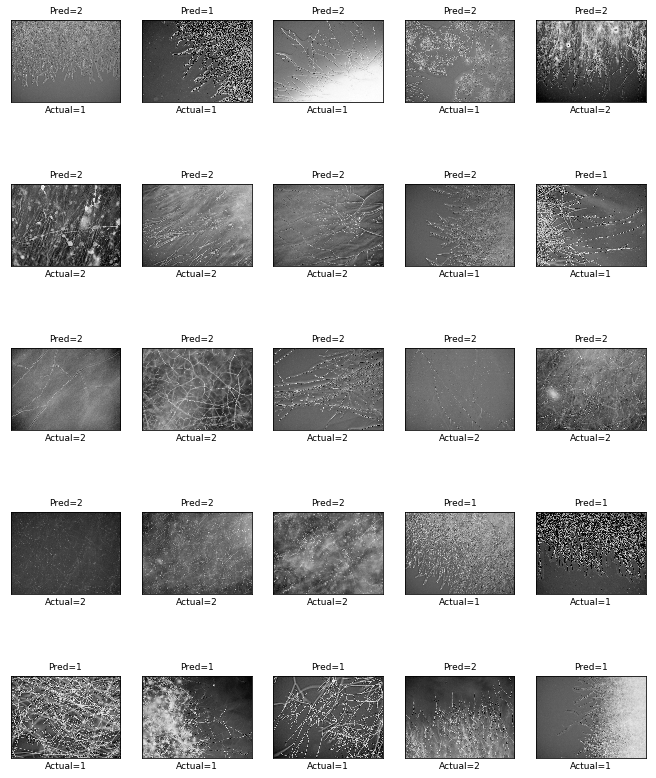

In [107]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title('Pred='+str(pred_titles[i]), size=9)
        plt.xlabel('Actual='+str(true_titles[i]), size=9)
        plt.xticks(())
        plt.yticks(())

plot_gallery(test_vectors, test_labels, pred_labels, h,w)

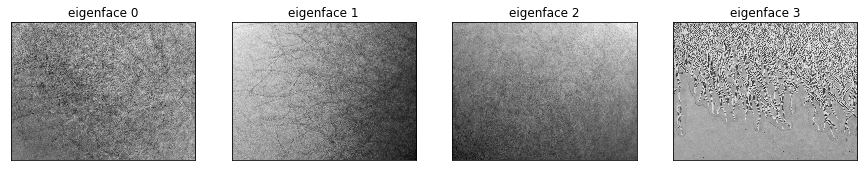

In [38]:
eigenfaces = pca.components_.reshape((n_components, h, w))
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=1, n_col=4)
#plt.imshow(eigenfaces[3])

In [6]:
fft_feature_vector = []
for i in photo_filenames:
    name = './Fungi Pics/' + i
    im = imread(name, flatten=True)
    gim = rgb2gray(im)
    Fs = np.fft.fft2(gim)
    F2 = np.fft.fftshift(Fs) 
    psd2D = np.abs(F2)
    flat_psd = psd2D.flatten()
    fft_feature_vector.append(flat_psd)
fft_feature_vector = np.array(fft_feature_vector)

In [51]:
fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, 
                                                                          labels, 
                                                                          random_state=1,
                                                                          test_size=0.50)

In [54]:
n_components = 8
fft_pca = PCA(n_components=n_components, whiten=True)
_ = fft_pca.fit(fft_train_vectors)
pickle.dump(fft_pca, open("hyphal_image_pca.obj", "wb"))

In [55]:
pca_fft_train_vectors = fft_pca.transform(fft_train_vectors)
pca_fft_test_vectors = fft_pca.transform(fft_test_vectors)
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pca_fft_train_vectors, fft_train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
end = time.time()
print("Runtime:", end-start)
pred_labels = clf.predict(pca_fft_test_vectors)
print(n_components, classification_report(fft_test_labels, pred_labels))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Runtime: 0.7785842418670654
8              precision    recall  f1-score   support

          1       0.91      0.62      0.74        32
          2       0.67      0.92      0.77        26

avg / total       0.80      0.76      0.76        58



0.952380952381 1345.805867433548
             precision    recall  f1-score   support

          1       0.86      0.75      0.80        32
          2       0.73      0.85      0.79        26

avg / total       0.80      0.79      0.79        58



(array([    4.,     6.,    38.,   196.,   528.,  1014.,  1137.,   688.,
          279.,    11.]),
 array([ 0.68      ,  0.7072381 ,  0.73447619,  0.76171429,  0.78895238,
         0.81619048,  0.84342857,  0.87066667,  0.89790476,  0.92514286,
         0.95238095]),
 <a list of 10 Patch objects>)

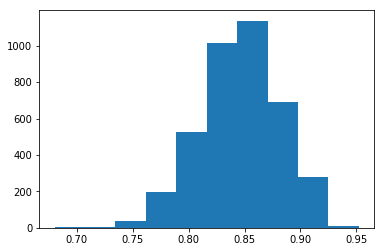

In [45]:
start = time.time()
Runtime = 0
#f_scores = []
#clf2 = RandomForestClassifier()
#clf2 = clf2.fit(fft_train_vectors, fft_train_labels)
#pred_labels2 = clf2.predict(fft_test_vectors)
#best_score = f1_score(fft_test_labels, pred_labels2)
while f1_score(fft_test_labels, pred_labels2) < 0.96 and Runtime < 7200:
    clf_temp = clf2.fit(fft_train_vectors, fft_train_labels)
    pred_labels2 = clf_temp.predict(fft_test_vectors)
    temp_score = f1_score(fft_test_labels, pred_labels2)
    f_scores.append(temp_score)
    if temp_score > best_score:
        clf2 = clf_temp
        pickle.dump(clf_temp, open("hyphal_image_RF_classifier2.obj", "wb"))
        best_score = temp_score
        print(best_score, Runtime)
    end = time.time()
    Runtime = end-start
print(classification_report(fft_test_labels, pred_labels2))
plt.hist(f_scores)

In [76]:
print(np.std(f_scores))
print(np.median(f_scores))
print(len(f_scores))
print(np.argmax(f_scores))
print((0.94 - np.mean(f_scores))/np.std(f_scores))

0.0351574230305
0.847457627119
3901
3530
2.68177074821


Text(0.5,1,'Distribution of Random Forest Classifiers')

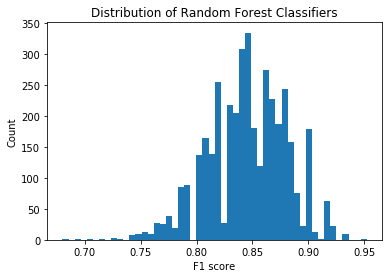

In [56]:
plt.hist(f_scores, bins=50);
plt.xlabel("F1 score")
plt.ylabel("Count")
plt.title("Distribution of Random Forest Classifiers")

In [47]:
pickle.dump(clf2, open("hyphal_image_RF_classifier.obj", "wb"))

In [52]:
clf2 = pickle.load(open("hyphal_image_RF_classifier.obj", 'rb'))

pred_labels = clf2.predict(fft_test_vectors)
print(f1_score(fft_test_labels, pred_labels))
print(classification_report(fft_test_labels, pred_labels))

0.952380952381
             precision    recall  f1-score   support

          1       0.97      0.94      0.95        32
          2       0.93      0.96      0.94        26

avg / total       0.95      0.95      0.95        58



In [71]:
pickle.dump(clf2, open("hyphal_image_RF_classifier2.obj", "wb"))

Text(0.5,1,'Principal Components Analysis')

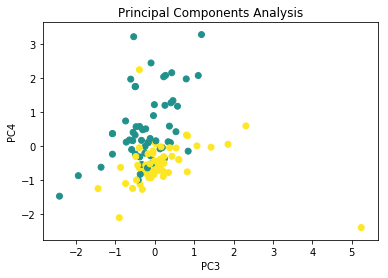

In [75]:
n1 = 2
n2 = 3
plt.scatter(pca_fft_test_vectors[:,n1], pca_fft_test_vectors[:,n2], c=test_labels, cmap='viridis', vmin = 0, vmax = 2)
plt.scatter(pca_fft_train_vectors[:,n1], pca_fft_train_vectors[:,n2], c=train_labels, cmap='viridis', vmin=0, vmax = 2)
plt.xlabel('PC'+str(n1+1))
plt.ylabel('PC'+str(n2+1))
plt.title("Principal Components Analysis")

In [5]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vector, 
                                                                          labels, 
                                                                          random_state=1,
                                                                          test_size=0.5)

In [6]:
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
_ = pca.fit(train_vectors)

pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
start = time.time()
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(pca_train_vectors, train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

#pickle.dump(clf, open(PCA_test_5comp, 'wb'))
end = time.time()
print("Runtime:", end-start)
pred_labels = clf.predict(pca_test_vectors)
print(n_components, classification_report(test_labels, pred_labels))
print(n_components, confusion_matrix(test_labels, pred_labels, labels=range(n_classes)))

In [76]:
test_labels

array([1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1], dtype=int64)

In [50]:
pred_labels = clf2.predict(pca_fft_test_vectors)
print(classification_report(fft_test_labels, pred_labels))

10              precision    recall  f1-score   support

          1       0.79      0.84      0.82        32
          2       0.79      0.73      0.76        26

avg / total       0.79      0.79      0.79        58



In [106]:
def photo_transform(im_name):
    '''
    Reads the image file and applies fast Fourier transform, then flattens it for use by the PCA and SVM algorithms.
    Input: image name, such as "./Fungi Pics/JU-15B.tif".
    Output: flattened and 2D array of frequency space
    '''
    im = imread(im_name, flatten=True) # read image and converts it to gray
    Fs = np.fft.fft2(im) # run fast Fourier transform on gray image
    F2 = np.fft.fftshift(Fs) # move the zero frequency component to the center
    psd2D = np.abs(F2) # remove imaginary values
    flat_psd = psd2D.flatten() # flatten the array
    flat_psd = flat_psd.reshape((1, -1)) # make it 2D for PCA and SVM
    return flat_psd
def photo_pred(flat_psd):
    '''
    Makes a prediction of which class the fungi is in when given a transformed image.
    Input: flattened 2D fft image from photo_transform
    Output: class prediction
    '''
    pca = pickle.load(open("hyphal_image_pca.obj", 'rb')) # load up-to-data PCA and SVM classifier
    clf = pickle.load(open("hyphal_image_classifier.obj", 'rb'))
    pca_psd = pca.transform(flat_psd) # transform with the PCA
    pred_label = clf.predict(pca_psd) # predict with the SVM
    if pred_label == 1: # return prediction decision
        return "Zygomycete"
    if pred_label == 2:
        return "Ascomycete or Basidiomycete"
def main(im_name):
    flat_psd = photo_transform(im_name)
    pred_label = photo_pred(flat_psd)
    print(pred_label)